In [16]:
import os 
import json
import requests
import textblob
import time
import re

import numpy as np
import pandas as pd
import keras.preprocessing.text as kpt
import matplotlib.pyplot as plt

from keras.models import load_model
from arcgis.gis import GIS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
from textblob import TextBlob

In [7]:
csv_path = r'Baltimore Riots Tweets/baltimore_twitter.csv'
model = load_model('models/Twitter_SA_Model.h5')

In [8]:
with open('dictionary/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

In [9]:
tokenizer = Tokenizer(num_words=20000)

In [10]:
def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])
        else:
            pass
            #print("'%s' not in training corpus; ignoring." %(word))
    return wordIndices

In [11]:
def Sentiment(tweet_text):
    labels = ['positive', 'negative']
    testArr = convert_text_to_index_array(tweet_text)
    twt = tokenizer.sequences_to_matrix([testArr], mode='binary')
    twt = pad_sequences(twt, maxlen=86, dtype='int32', padding='post', truncating='post', value=0)
    sentiment = model.predict(twt)
    accuracy = sentiment[0][np.argmax(sentiment)] * 100
    tweetSent = labels[np.argmax(sentiment)]
    return tweetSent, accuracy

In [12]:
def calculate_sentiment(object_id, text_to_analyze):
    sent_sp = TextBlob(text_to_analyze)
    subjectivity = sent_sp.sentiment.subjectivity
    polarity = sent_sp.sentiment.polarity
    sentiment_tf = Sentiment(text_to_analyze)
    classification_tf = sentiment_tf[0]
    if classification_tf == 'positive':
        classification_num = 1
    else:
        classification_num = 0
    accuracy_tf = sentiment_tf[1]
    text_sentiment = [object_id, subjectivity, polarity, classification_tf, accuracy_tf, classification_num]
    return text_sentiment

In [13]:
df = pd.read_csv(csv_path)
df.dropna()
text_df = df[['OBJECTID', 'text']]

In [17]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [18]:
df.head()

,OBJECTID,lat,long,dtg,user_name,user_id,text
0,1,39.274819,-76.608696,Mon Apr 27 23:00:57 +0000 2015,PandaMc8,3.880081e+08,wtffffff httpstco2dt5pxqoc2
1,2,39.292146,-76.567825,Mon Apr 27 23:01:15 +0000 2015,okaykerra,3.519059e+08,pretty rick been everywhere and aint been aint...
2,3,39.293876,-76.682365,Mon Apr 27 23:01:41 +0000 2015,letgoletkarma,4.498094e+07,im filing exempt tomorrow
3,4,39.309108,-76.666054,Mon Apr 27 23:01:47 +0000 2015,PrettyMoee,2.656314e+08,i got endless videos
4,5,39.281066,-76.631622,Mon Apr 27 23:02:05 +0000 2015,khyona_,2.157380e+09,omg they mace the man


In [13]:
df_shape = df.shape
print("Total Rows:  " + repr(df_shape[0]))
print("Total Columns:  " + repr(df_shape[1]))

Total Rows:  23137
Total Columns:  7


In [14]:
sentiment_list =[]

start_time = time.time()
print(start_time)

errors = 0

for row in text_df.iterrows():
    oid = row[1]['OBJECTID']
    text = row[1]['text']
    if text != None:
        try:
            classified_text = calculate_sentiment(oid, text)
            sentiment_list.append(classified_text)
            #print(classified_text)
        except:
            errors +=1
            print("Error on oid " + str(oid))
            
    
end_time = time.time()
print(end_time - start_time)
print("Process completed with an error percentage of " + repr((errors/df_shape[0]) * 100))

1539625632.4249065
151.65324521064758
Process completed with an error percentage of 0.0


In [15]:
sentiment_columns = ['OBJECTID', 'Subjectivity', 'Polarity', 'Sentiment', 'Accuracy', 'Classification']
sentiment_df = pd.DataFrame(sentiment_list, columns=sentiment_columns)
sentiment_df.head()

,OBJECTID,Subjectivity,Polarity,Sentiment,Accuracy,Classification
0,1,0.00,0.000000,negative,61.184597,0
1,2,1.00,0.390625,negative,61.184955,0
2,3,0.00,0.000000,negative,61.184597,0
3,4,0.75,-0.125000,negative,61.245066,0
4,5,0.00,0.000000,negative,61.184657,0


In [16]:
merged_df = pd.merge(df, sentiment_df, on='OBJECTID')
merged_df.head()

,OBJECTID,lat,long,dtg,user_name,user_id,text,Subjectivity,Polarity,Sentiment,Accuracy,Classification
0,1,39.274819,-76.608696,Mon Apr 27 23:00:57 +0000 2015,PandaMc8,3.880081e+08,WTFFFFFF https://t.co/2DT5PxqOc2,0.00,0.000000,negative,61.184597,0
1,2,39.292146,-76.567825,Mon Apr 27 23:01:15 +0000 2015,okaykerra,3.519059e+08,Pretty Rick been everywhere and ain't been ain...,1.00,0.390625,negative,61.184955,0
2,3,39.293876,-76.682365,Mon Apr 27 23:01:41 +0000 2015,letgoletkarma,4.498094e+07,I'm filing exempt tomorrow,0.00,0.000000,negative,61.184597,0
3,4,39.309108,-76.666054,Mon Apr 27 23:01:47 +0000 2015,PrettyMoee,2.656314e+08,I got endless videos,0.75,-0.125000,negative,61.245066,0
4,5,39.281066,-76.631622,Mon Apr 27 23:02:05 +0000 2015,khyona_,2.157380e+09,Omg they mace the man,0.00,0.000000,negative,61.184657,0


In [17]:
import re

mentions = []

for row in merged_df.iterrows():
    oid = row[1]['OBJECTID']
    text = row[1]['text']
    user = row[1]['user_name']
    match = re.findall(r'@(?i)[a-z0-9_]+', text)
    if len(match) > 0:
        for handle in match:
            mentions.append(["@" + user, handle])

C:\Users\jame9353\AppData\Local\ESRI\conda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Flags not at the start of the expression '@(?i)[a-z0-9_]+'
  if __name__ == '__main__':


In [18]:
len(mentions)

7016

In [19]:
mentions_columns = ['User', 'Mentioned']
mentions_df = pd.DataFrame(mentions, columns=mentions_columns)
mentions_df.head()

,User,Mentioned
0,@lizbreaux,@EternalWeather1
1,@latisha_92,@TrinaBraxton
2,@HotBoy_Gotti,@im_taedoe_bitch
3,@latisha_92,@towandabraxton
4,@HousingWatchMD,@mbta535


In [20]:
merged_df.to_csv('output/SentimentData.csv')
mentions_df.to_csv('output/TwitterMentions.csv')

In [21]:
from arcgis.features import SpatialDataFrame

spatial_df = SpatialDataFrame.from_xy(merged_df, 'long', 'lat', sr=4326)

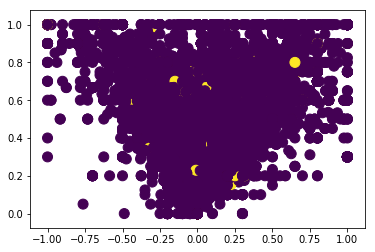

In [22]:
plt.scatter(spatial_df.Polarity, merged_df.Subjectivity, s=100, c=merged_df.Classification)